In [369]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import matplotlib.cm as cm
#from IPython.display import JSON
import math
import inspect
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer

In [370]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 100)

In [371]:
def get_unique_links(df):
    #unique_links = df['link'].unique()
    unique_links = df['link'].unique().tolist()
    return unique_links

In [372]:
def get_nonunique_links(df):
    nonunique_links = df[df.duplicated(['link'])]['link']
    #nonunique_links = df[df.duplicated(['link'])]['link'].tolist()
    return nonunique_links

In [373]:
def show_df_info(df: pd.DataFrame) -> pd.DataFrame:
    """
    Prints information about a DataFrame, including column names, data types, and non-null counts.
    
    Args:
        df (pandas.DataFrame): The DataFrame to process.
        
    Returns:
        pandas.DataFrame: A DataFrame containing the column names, data types, and non-null counts, and null counts of the input DataFrame.
    """
    col_names = df.columns.to_list()
    col_dtypes = df.dtypes.to_list()
    non_null_counts = df.count().to_list()
    null_counts = df.isnull().sum().to_list()
    info_df = pd.DataFrame({'column_name': col_names, 'dtype': col_dtypes, 'non_null_count': non_null_counts, 'null_count': null_counts})

    caller_frame = inspect.currentframe().f_back
    df_name = [var_name for var_name, var_val in caller_frame.f_locals.items() if var_val is df][0]

    print(f"DataFrame '{df_name}' has {len(df)} rows and {len(df.columns)} columns.")
    print("Here is a summary of the column names, data types and null counts:")
    return info_df

In [374]:
def multiplot(df):
    # define subplots
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

    #fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), gridspec_kw={'hspace': 0.2, 'wspace': 0.1})
    # Q-Q plot
    st.probplot(df['percent_human'], dist='norm', plot=axs[0, 0])
    axs[0, 0].set_title('Figure 1: Q-Q Plot of Percent Human')
    axs[0, 0].set_xlabel('Theoretical quantiles')
    axs[0, 0].set_ylabel('Sample quantiles')
    axs[0, 0].text(0.02, 0.95, 'Data is not normally distributed\nand cannot be evaluated using Pearson\'s method', transform=axs[0, 0].transAxes, fontsize=12, verticalalignment='top', color='black')

    # Histogram
    skewness = round(st.skew(df['percent_human']),2)
    sns.histplot(data=df['percent_human'], kde=False, binwidth=1, color='green', ax=axs[0, 1])
    axs[0, 1].set_title('Figure 2: Histogram of Percent Human')
    axs[0, 1].set_xlabel('Percent Human')
    axs[0, 1].set_ylabel('Count')
    axs[0, 1].set_xlim(0, None)
    axs[0, 1].set_ylim(0, None)
    axs[0, 1].text(0.02, 0.95, f'Data has high Skewness ({skewness})', transform=axs[0, 1].transAxes, fontsize=12, verticalalignment='top', color='black')
    axs[0, 1].text(0.02, 0.90, f'Over 1/3 of data in top 2%', transform=axs[0, 1].transAxes, fontsize=12, verticalalignment='top', color='black')


    # Scatter plot of percent_human vs rank
    sns.scatterplot(data=df, x='rank', y='percent_human', color='green', alpha=0.05, s=200, edgecolor=None, ax=axs[1, 0])
    axs[1, 0].set_title('Figure 3: Scatter Plot of Percent Human vs Rank')
    axs[1, 0].set_xlabel('Rank')
    axs[1, 0].set_ylabel('Percent Human')
    axs[1, 0].set_xticks(np.arange(1, 21))

    # Scatter plot of mean percent_human vs. rank
    grouped_data = df.groupby('rank')
    mean_percent_human = grouped_data['percent_human'].mean().reset_index()
    sns.scatterplot(ax=axs[1, 1], data=mean_percent_human, x='rank', y='percent_human',  color='green')
    sns.regplot(ax=axs[1, 1], data=mean_percent_human, x='rank', y='percent_human', color='green', scatter=False, line_kws={'linestyle':'--'})
    axs[1, 1].set_title('Figure 4: Scatter Plot of Mean Percent Human vs Rank')
    axs[1, 1].set_xlabel('Rank')
    axs[1, 1].set_ylabel('Mean Percent Human')
    axs[1, 1].set_xticks(np.arange(1, 21))
    axs[1, 1].legend(handles=axs[1, 1].lines[::len(mean_percent_human)], labels=['Best fit line'])
    axs[1, 1].text(0.02, 0.05, f'Percent Human is weakly correlated to Rank with a high degree of certainty', transform=axs[1, 1].transAxes, fontsize=10, verticalalignment='top', color='black')


    # Calculate correlation coefficients and p-values
    pb_corr, pb_pval = st.pointbiserialr(df['rank'], df['percent_human'])
    spearman_corr, spearman_pval = st.spearmanr(df['rank'], df['percent_human'])
    kendall_tau, kendall_pval = st.kendalltau(df['rank'], df['percent_human'])

    # Create a dictionary to store the results
    corr = {
        'Method': ['Point Biserial', 'Spearman', 'Kendall'],
        'Correlation Coefficient': [pb_corr, spearman_corr, kendall_tau],
        'P-value': [pb_pval, spearman_pval, kendall_pval]
    }

    for key in corr:
        if isinstance(corr[key][0], float):
            corr[key] = [round(val, 4) for val in corr[key]]


    # Create a pandas dataframe from the dictionary
    df_corr = pd.DataFrame(corr)

    # Create a table to display the correlation coefficients and p-values
    col_labels = ['Method', 'Corr Coef', 'P-value']
    table_data = [col_labels] + df_corr.values.tolist()

    table = axs[1, 1].table(cellText=table_data,
                    colLabels=None,
                    cellLoc='center',
                    bbox=[0.02, 0.08, 0.5, 0.15])  # x, y, width, height
    table.set_fontsize(10)

    # Format the table to use 4 significant figures
    for i in range(1, len(table_data)):
        for j in range(1, 3):
            cell = table.get_celld()[i, j]
            cell_text = cell.get_text().get_text()
            cell_text = float(cell_text)
            cell_text = f'{cell_text:.4g}'
            cell.get_text().set_text(cell_text)

    fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
    fig.savefig('figures/Fig_1-4.png')
    plt.show()

In [375]:
def multiplotv(df, filter_col=None, fmin=None, fmax=None):
    # define subplots
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

    # apply main title
    main_title = f'Correlation Study: Rank vs Percent Human ({len(df)} data points)'
    fig.suptitle(main_title, fontsize=16, fontweight='bold', y=.98)

    # apply filter and subtitle
    if filter_col:
        if fmin is not None and fmax is not None:
            if fmin < fmax:
                fig.text(0.5, 0.94, f'Filtered on {fmin} < {filter_col} < {fmax}', ha='center', fontsize=16)
                df = df[(df[filter_col] <= fmax) & (df[filter_col] >= fmin)]
            else:
                fmin, fmax = fmax, fmin
                fig.text(0.5, 0.94, f'Filtered on {fmin} > {filter_col} > {fmax}', ha='center', fontsize=16)
                df = df[(df[filter_col] >= fmax) | (df[filter_col] <= fmin)]
        elif fmin is not None and fmax is None:
            fig.text(0.5, 0.94, f'Filtered on {filter_col} > {fmin}', ha='center', fontsize=16)
            df = df[df[filter_col] >= fmin]
        elif fmin is None and fmax is not None:
            fig.text(0.5, 0.94, f'Filtered on {filter_col} < {fmax}', ha='center', fontsize=16)
            df = df[df[filter_col] <= fmax]
        else:
            print(f'Warning: you must provide a min and/or max on which to filter on {filter_col} or no filtering will occur')

        
    # Fig 1: Q-Q plot [0, 0]
    st.probplot(df['percent_human'], dist='norm', plot=axs[0, 0])
    axs[0, 0].set_title('Figure 1: Q-Q Plot of Percent Human')
    axs[0, 0].set_xlabel('Theoretical quantiles')
    axs[0, 0].set_ylabel('Sample quantiles')
    axs[0, 0].text(0.02, 0.95, 'Data is not normally distributed\nand cannot be evaluated using Pearson\'s method', transform=axs[0, 0].transAxes, fontsize=12, verticalalignment='top', color='black')

    
    # Fig 2: Histogram [0, 1]
    sns.histplot(data=df['percent_human'], kde=False, binwidth=1, color='green', ax=axs[0, 1])
    axs[0, 1].set_title('Figure 2: Histogram of Percent Human')
    axs[0, 1].set_xlabel('Percent Human')
    axs[0, 1].set_ylabel('Count')
    axs[0, 1].set_xlim(-5, 105)
    axs[0, 1].set_ylim(0, None)
    skewness = round(st.skew(df['percent_human']),2)
    axs[0, 1].text(0.02, 0.95, f'Data Skewness {skewness}', transform=axs[0, 1].transAxes, fontsize=12, verticalalignment='top', color='black')
    #axs[0, 1].text(0.02, 0.90, f'Over 1/3 of data in top 2%', transform=axs[0, 1].transAxes, fontsize=12, verticalalignment='top', color='black')

    
    # Fig 3: Violin plot [1, 0]
    sns.violinplot(ax=axs[1, 0], data=df, x="rank", y="percent_human", scale="count", inner="box", color="#00aa00", saturation=0.5, cut=0, linewidth=.9)#, edgecolor='#ffffff')

        # plot mean lines
    for i, mean in enumerate(df.groupby("rank")["percent_human"].mean()):
        axs[1, 0].hlines(mean, i-0.25, i+0.25, linewidth=1, color='#444444', zorder=100)

        # plot median markers
    median_markers = df.groupby('rank')['percent_human'].median()
    sns.scatterplot(ax=axs[1, 0], x=median_markers.index-1, y=median_markers.values, marker='o', s=20, color='white', edgecolor='black', zorder=100)
    
    axs[1, 0].set_title('Fig 3:Percent Human vs Rank')
    #axs[1, 0].set_facecolor('#ffffff')
    axs[1, 0].set_xlabel("Rank",size = 16,alpha=0.7)
    axs[1, 0].set_ylabel("Percent Human",size = 16,alpha=0.7)

   
    # Fig 4: Scatter plot [1, 1]
    grouped_data = df.groupby('rank')
    mean_percent_human = grouped_data['percent_human'].mean().reset_index()
    sns.scatterplot(ax=axs[1, 1], data=mean_percent_human, x='rank', y='percent_human',  color='green')
    sns.regplot(ax=axs[1, 1], data=mean_percent_human, x='rank', y='percent_human', color='green', scatter=False, line_kws={'linestyle':'--'})
    axs[1, 1].set_title('Figure 4: Scatter Plot of Mean Percent Human vs Rank')
    axs[1, 1].set_xlabel('Rank')
    axs[1, 1].set_ylabel('Mean Percent Human')
    axs[1, 1].set_xticks(np.arange(1, 21))
    axs[1, 1].legend(handles=axs[1, 1].lines[::len(mean_percent_human)], labels=['Best fit line'])
    axs[1, 1].text(0.02, 0.05, f'Percent Human is weakly correlated to Rank with a high degree of certainty', transform=axs[1, 1].transAxes, fontsize=10, verticalalignment='top', color='black')

        # Calculate correlation coefficients and p-values
    pb_corr, pb_pval = st.pointbiserialr(df['rank'], df['percent_human'])
    spearman_corr, spearman_pval = st.spearmanr(df['rank'], df['percent_human'])
    kendall_tau, kendall_pval = st.kendalltau(df['rank'], df['percent_human'])

        # Create a dictionary to store the results
    corr = {
        'Method': ['Point Biserial', 'Spearman', 'Kendall'],
        'Correlation Coefficient': [pb_corr, spearman_corr, kendall_tau],
        'P-value': [pb_pval, spearman_pval, kendall_pval]
    }

        # Create a pandas dataframe from the corr dict
    df_corr = pd.DataFrame(corr)

        # Create a table to display the correlation coefficients and p-values
    col_labels = ['Method', 'Corr Coef', 'P-value']
    table_data = [col_labels] + df_corr.values.tolist()

    table = axs[1, 1].table(cellText=table_data,
                    colLabels=None,
                    cellLoc='center',
                    bbox=[0.02, 0.08, 0.5, 0.15])  # x, y, width, height
    table.set_fontsize(10)

        # Format the table to use 4 significant figures
    for i in range(1, len(table_data)):
        for j in range(1, 3):
            cell = table.get_celld()[i, j]
            cell_text = cell.get_text().get_text()
            cell_text = float(cell_text)
            cell_text = f'{cell_text:.4g}'
            cell.get_text().set_text(cell_text)

    # shrink outer margin
    fig.subplots_adjust(left=0.05, right=0.95, top=.90, bottom=0.05)
   
    fig.savefig('figures/Fig_1-4.png')
    plt.show()

In [376]:
def multiplotv_dark(df: pd.DataFrame, filter_col: str = None, fmin: float = None, fmax: float = None) -> None:
    """
    Generate a set of 4 plots to visualize the relationship between two variables in a DataFrame.
    :param df: DataFrame containing the data
    :param filter_col: Name of the column to filter on (optional)
    :param filter_min: Minimum value for the filter_col (optional)
    :param filter_max: Maximum value for the filter_col (optional)
    """

    # define subplots
    face_color = '0.1'
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), facecolor=face_color)
    
    # Set background color to black
    #plt.style.use('dark_background')

    # apply filter and subtitle
    if filter_col:
        if fmin is not None and fmax is not None:
            if fmin < fmax:
                fig.text(0.5, 0.94, f'Filtered on {fmin} < {filter_col} < {fmax}', ha='center', fontsize=16, color='white')
                df = df[(df[filter_col] <= fmax) & (df[filter_col] >= fmin)]
            else:
                fmin, fmax = fmax, fmin
                fig.text(0.5, 0.94, f'Filtered on {fmin} > {filter_col} > {fmax}', ha='center', fontsize=16, color='white')
                df = df[(df[filter_col] >= fmax) | (df[filter_col] <= fmin)]
        elif fmin is not None and fmax is None:
            fig.text(0.5, 0.94, f'Filtered on {filter_col} > {fmin}', ha='center', fontsize=16, color='white')
            df = df[df[filter_col] >= fmin]
        elif fmin is None and fmax is not None:
            fig.text(0.5, 0.94, f'Filtered on {filter_col} < {fmax}', ha='center', fontsize=16, color='white')
            df = df[df[filter_col] <= fmax]
        else:
            print(f'Warning: you must provide a min and/or max on which to filter on {filter_col} or no filtering will occur')

    # apply main title
    main_title = f'Correlation Study: Rank vs Percent Human ({len(df)} data points)'
    fig.suptitle(main_title, fontsize=20, fontweight='bold', y=.98, color='white')
    
    
    # Fig 1: Q-Q plot [0, 0]
    st.probplot(df['percent_human'], dist='norm', plot=axs[0, 0])
    axs[0, 0].set_title('Figure 1: Q-Q Plot of Percent Human')
    axs[0, 0].set_xlabel('Theoretical quantiles')
    axs[0, 0].set_ylabel('Sample quantiles')
    axs[0, 0].text(0.02, 0.95, 'Data is not normally distributed\nand cannot be evaluated using Pearson\'s method', transform=axs[0, 0].transAxes, fontsize=12, verticalalignment='top', color='white')

    
    # Fig 2: Histogram [0, 1]
    sns.histplot(data=df['percent_human'], kde=False, binwidth=1, color='green', ax=axs[0, 1], edgecolor='grey')
    axs[0, 1].set_title('Figure 2: Histogram of Percent Human')
    axs[0, 1].set_xlabel('Percent Human')
    axs[0, 1].set_ylabel('Count')
    axs[0, 1].set_xlim(-5, 105)
    axs[0, 1].set_ylim(0, None)
    skewness = round(st.skew(df['percent_human']), 2)
    axs[0, 1].text(0.02, 0.95, f'Data Skewness {skewness}', transform=axs[0, 1].transAxes, fontsize=12, verticalalignment='top', color='white')
    #axs[0, 1].text(0.02, 0.90, f'Over 1/3 of data in top 2%', transform=axs[0, 1].transAxes, fontsize=12, verticalalignment='top', color='black')

    
    # Fig 3: Violin plot [1, 0]
    sns.violinplot(ax=axs[1, 0], data=df, x="rank", y="percent_human", scale="count", inner="box", color="#00aa00", saturation=0.5, cut=0, linewidth=.9)

        # plot mean lines
    for i, mean in enumerate(df.groupby("rank")["percent_human"].mean()):
        axs[1, 0].hlines(mean, i-0.25, i+0.25, linewidth=1, color='#bbbbbb', zorder=100)

        # plot median markers
    median_markers = df.groupby('rank')['percent_human'].median()
    sns.scatterplot(ax=axs[1, 0], x=median_markers.index-1, y=median_markers.values, marker='o', s=20, color='white', edgecolor='black', zorder=100)
    
    axs[1, 0].set_title('Figure 3: Percent Human vs Rank')
    axs[1, 0].set_xlabel('Rank')
    axs[1, 0].set_ylabel('Percent Human')

   
    # Fig 4: Scatter plot [1, 1]
    grouped_data = df.groupby('rank')
    mean_percent_human = grouped_data['percent_human'].mean().reset_index()
    sns.scatterplot(ax=axs[1, 1], data=mean_percent_human, x='rank', y='percent_human',  color='green', edgecolor=None)
    sns.regplot(ax=axs[1, 1], data=mean_percent_human, x='rank', y='percent_human', color='green', scatter=False, line_kws={'linestyle':'--'})
    axs[1, 1].set_title('Figure 4: Mean Percent Human vs Rank')
    axs[1, 1].set_xlabel('Rank')
    axs[1, 1].set_ylabel('Mean Percent Human')
    axs[1, 1].set_xticks(np.arange(1, 21))
    axs[1, 1].legend(handles=axs[1, 1].lines[::len(mean_percent_human)], labels=['Best fit line'], facecolor=face_color, labelcolor='white')
    axs[1, 1].text(0.02, 0.05, f'Percent Human is weakly correlated to Rank with a high degree of certainty', transform=axs[1, 1].transAxes, fontsize=10, verticalalignment='top', color='white')

        # Calculate correlation coefficients and p-values
    pb_corr, pb_pval = st.pointbiserialr(df['rank'], df['percent_human'])
    spearman_corr, spearman_pval = st.spearmanr(df['rank'], df['percent_human'])
    kendall_tau, kendall_pval = st.kendalltau(df['rank'], df['percent_human'])

        # Create a dictionary to store the results
    corr = {
        'Method': ['Point Biserial', 'Spearman', 'Kendall'],
        'Corr Coef': [pb_corr, spearman_corr, kendall_tau],
        'P-value': [pb_pval, spearman_pval, kendall_pval]
    }

        # Create a pandas dataframe from the corr dict
    df_corr = pd.DataFrame(corr)

        # Create a table to display the correlation coefficients and p-values
    table_data = [list(df_corr.columns)] + df_corr.values.tolist()
    table = axs[1, 1].table(cellText=table_data,
                    colLabels=None,
                    cellLoc='center',
                    bbox=[0.02, 0.08, 0.5, 0.15],  # x, y, width, height
                    cellColours=[[face_color]*3] + [[face_color]*3]*len(df_corr))
    table.set_fontsize(10)
    for cell in table.get_celld().values():
        cell.set_linewidth(0)
        cell.set_edgecolor('none')
        cell.set_text_props(color='white')


        # Format the table to use 4 significant figures
    for i in range(1, len(table_data)):
        for j in range(1, 3):
            cell = table.get_celld()[i, j]
            cell_text = cell.get_text().get_text()
            cell_text = float(cell_text)
            cell_text = f'{cell_text:.4g}'
            cell.get_text().set_text(cell_text)
            #cell.set_edgecolor('white')
    
    font_color = '#cccccc'
    for ax in axs.flat:
        ax.tick_params(axis='x', labelsize=12, colors=font_color)
        ax.tick_params(axis='y', labelsize=12, colors=font_color)
        ax.set_xlabel(ax.get_xlabel(), fontdict={'fontsize': 14, 'color': font_color})
        ax.set_ylabel(ax.get_ylabel(), fontdict={'fontsize': 14, 'color': font_color})
        ax.set_title(ax.get_title(), fontdict={'fontsize': 16, 'color': 'white'})
        ax.set_facecolor(face_color)
        for spine in ax.spines.values():
            spine.set_edgecolor('white')
            #spine.set_linewidth(2)
    
    # shrink outer margin
    fig.subplots_adjust(left=0.05, right=0.95, top=.90, bottom=0.05)
   
    fig.savefig('figures/Fig_1-4.png')
    plt.show()

In [377]:
def compare_files(file1_path: str, file2_path: str) -> bool:
    """
    Compare the contents of two text files and return True if they are identical, False otherwise.

    :param file1_path: The path of the first file to compare.
    :param file2_path: The path of the second file to compare.
    :return: True if the contents of the two files are identical, False otherwise.
    """
    with open(file1_path, 'r') as file1, open(file2_path, 'r') as file2:
        # Read the entire contents of each file into memory.
        file1_contents = file1.read()
        file2_contents = file2.read()

        # Compare the contents of the two files.
        return file1_contents == file2_contents

In [378]:
df = pd.read_csv('data/data_clean.csv')
df.head(1)

,kw,rank,link,success,word_count,percent_human,percent_ai,uid
0,how to finish concrete,1,https://www.familyhandyman.com/project/how-to-...,True,1689.0,99.926081,0.073917,how to finish concrete_1_https://www.familyhan...


In [379]:
show_df_info(df)

DataFrame 'df' has 14637 rows and 8 columns.
Here is a summary of the column names, data types and null counts:


,column_name,dtype,non_null_count,null_count
0,kw,object,14637,0
1,rank,int64,14637,0
2,link,object,14637,0
3,success,bool,14637,0
4,word_count,float64,14637,0
5,percent_human,float64,14637,0
6,percent_ai,float64,14637,0
7,uid,object,14637,0


In [380]:
# load the old version of kw_1_000
kw1000 = pd.read_csv('data/kw_1_000.old.csv', header=0)
kw1000 = kw1000.rename(columns={'Keyword': 'kw'})
kw1000 = kw1000.drop(['Volume', 'URL'], axis=1 )
show_df_info(kw1000)

DataFrame 'kw1000' has 1000 rows and 2 columns.
Here is a summary of the column names, data types and null counts:


,column_name,dtype,non_null_count,null_count
0,kw,object,1000,0
1,SERP features,object,996,4


In [381]:
# merge the SERP features back in
df = pd.merge(left=df, right=kw1000, left_on='kw', right_on='kw', how='left')
df['SERP features'] = df['SERP features'].fillna('none')
df = df.rename(columns={'SERP features': 'serp_feat'})
df.head(1)

,kw,rank,link,success,word_count,percent_human,percent_ai,uid,serp_feat
0,how to finish concrete,1,https://www.familyhandyman.com/project/how-to-...,True,1689.0,99.926081,0.073917,how to finish concrete_1_https://www.familyhan...,"Videos, People also ask"


In [382]:
show_df_info(df)

DataFrame 'df' has 14637 rows and 9 columns.
Here is a summary of the column names, data types and null counts:


,column_name,dtype,non_null_count,null_count
0,kw,object,14637,0
1,rank,int64,14637,0
2,link,object,14637,0
3,success,bool,14637,0
4,word_count,float64,14637,0
5,percent_human,float64,14637,0
6,percent_ai,float64,14637,0
7,uid,object,14637,0
8,serp_feat,object,14637,0


In [383]:
mlb = MultiLabelBinarizer()
one_hot = pd.DataFrame(mlb.fit_transform(df['serp_feat'].str.split(', ')), columns=mlb.classes_)
df = pd.concat([df, one_hot], axis=1)
df = df.drop(['serp_feat', 'none'], axis=1)
df.head(1)

,kw,rank,link,success,word_count,percent_human,percent_ai,uid,Adwords bottom,Adwords sitelink,Adwords top,Featured snippet,Image pack,Knowledge card,Knowledge panel,Local pack,Local teaser,People also ask,Shopping results,Sitelinks,Thumbnail,Top stories,Tweet box,Video preview,Videos
0,how to finish concrete,1,https://www.familyhandyman.com/project/how-to-...,True,1689.0,99.926081,0.073917,how to finish concrete_1_https://www.familyhan...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [384]:
show_df_info(df)

DataFrame 'df' has 14637 rows and 25 columns.
Here is a summary of the column names, data types and null counts:


,column_name,dtype,non_null_count,null_count
0,kw,object,14637,0
1,rank,int64,14637,0
2,link,object,14637,0
3,success,bool,14637,0
4,word_count,float64,14637,0
...,...,...,...,...
20,Thumbnail,int64,14637,0
21,Top stories,int64,14637,0
22,Tweet box,int64,14637,0
23,Video preview,int64,14637,0


In [385]:
def get_feature_counts(df, columns):
    feature_counts = {}
    for column in columns:
        count = df[column].sum()
        feature_counts[column] = count
    feature_counts = dict(sorted(feature_counts.items(), key=lambda x: x[1], reverse=True))
    return feature_counts

In [386]:
columns = ['Adwords bottom', 'Adwords sitelink', 'Adwords top', 'Featured snippet', 'Image pack', 'Knowledge card', 'Knowledge panel', 'Local pack', 'Local teaser', 'People also ask', 'Shopping results', 'Sitelinks', 'Thumbnail', 'Top stories', 'Tweet box', 'Video preview', 'Videos']
counts = get_feature_counts(df, columns)
counts

{'People also ask': 13034,
 'Sitelinks': 10612,
 'Thumbnail': 6282,
 'Shopping results': 4864,
 'Featured snippet': 4680,
 'Image pack': 4326,
 'Video preview': 3024,
 'Knowledge panel': 2522,
 'Videos': 1778,
 'Top stories': 815,
 'Local pack': 462,
 'Adwords top': 253,
 'Adwords bottom': 225,
 'Adwords sitelink': 166,
 'Local teaser': 126,
 'Knowledge card': 31,
 'Tweet box': 19}

In [387]:
df.to_csv('data/data_clean_final.csv', index=False)

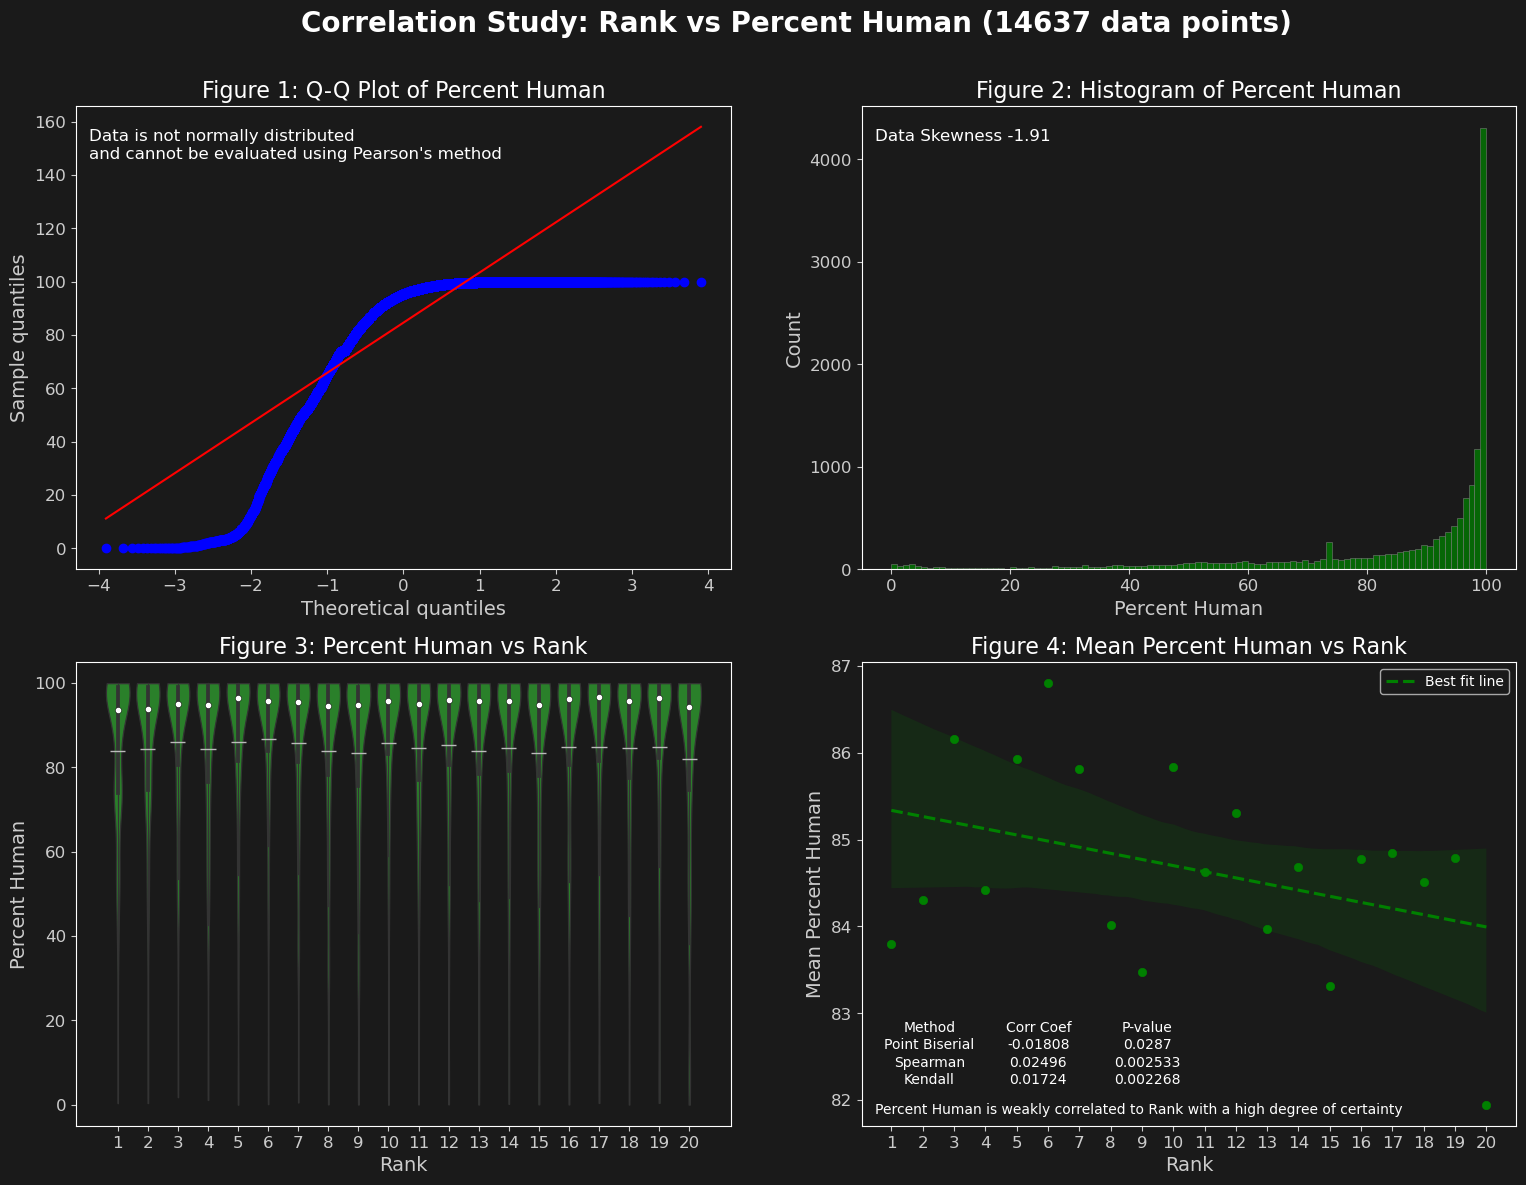

In [388]:
multiplotv_dark(df)

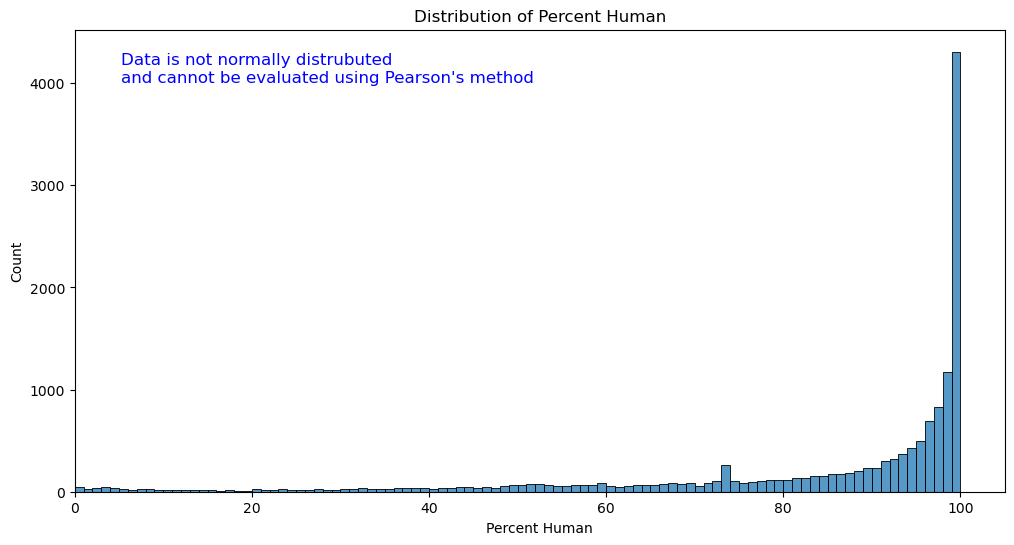

In [389]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.histplot(df['percent_human'], kde=False, binwidth=1)
ax.set(title='Distribution of Percent Human', xlabel='Percent Human', ylabel='Count', xlim=(0, None), ylim=(0, None))
ax.text(0.05, 0.95, 'Data is not normally distrubuted\nand cannot be evaluated using Pearson\'s method', transform=ax.transAxes, fontsize=12, verticalalignment='top', color='blue')
plt.show()

In [390]:
df['word_count'].max()

183712.0

/home/mike/miniconda3/envs/stats/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


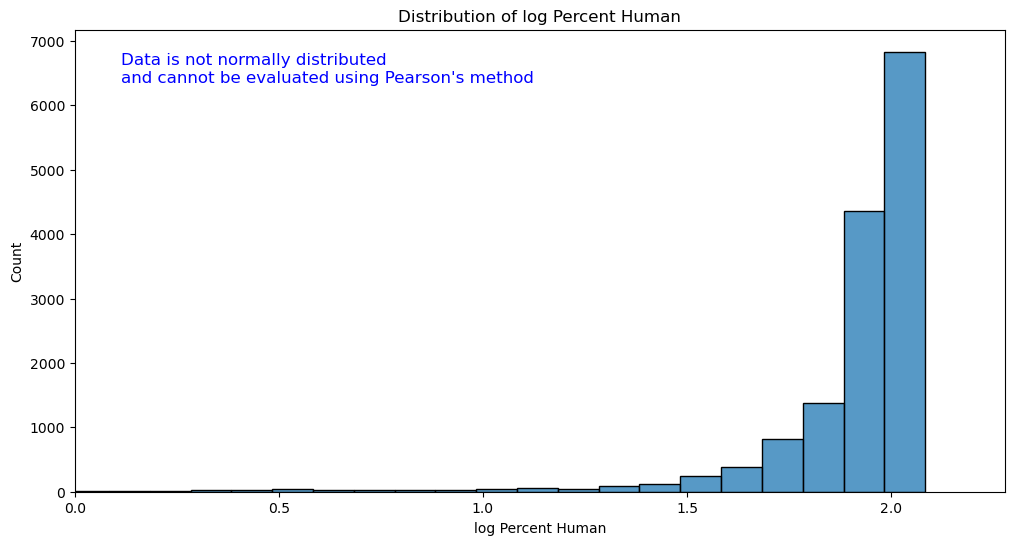

In [391]:
# Calculate the log base 10 of percent_human
df['log_percent_human'] = np.log10(df['percent_human'])

# Create the histogram plot
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.histplot(df['log_percent_human'], kde=False, binwidth=0.1)

# Set the plot properties
ax.set(title='Distribution of log Percent Human', xlabel='log Percent Human', ylabel='Count', xlim=(0, None), ylim=(0, None))
ax.text(0.05, 0.95, 'Data is not normally distributed\nand cannot be evaluated using Pearson\'s method', transform=ax.transAxes, fontsize=12, verticalalignment='top', color='blue')

plt.show()

In [392]:
# # TAKES FOREVER TO PLOT

# fig, ax = plt.subplots(figsize=(12, 6))
# ax = sns.histplot(df['word_count'], kde=False, binwidth=1)
# ax.set(title='Distribution of word_count', xlabel='word_count', ylabel='Count', xlim=(0, None), ylim=(0, None))
# ax.text(0.05, 0.95, 'Data is not normally distrubuted\nand cannot be evaluated using Pearson\'s method', transform=ax.transAxes, fontsize=12, verticalalignment='top', color='blue')
# plt.show()

In [393]:
df[df['word_count'] <120].count()

kw                   383
rank                 383
link                 383
success              383
word_count           383
                    ... 
Top stories          383
Tweet box            383
Video preview        383
Videos               383
log_percent_human    383
Length: 26, dtype: int64

In [394]:
df2 = df[(df['word_count'] < 5000) & (df['word_count'] > 150)]

In [395]:
df2['word_count'].mean()

1193.1025660264106

In [396]:
df['word_count'].skew()

22.13212845560128

In [397]:
df2['word_count'].skew()

1.4788125730672794

In [398]:
# # TAKES FOREVER TO PLOT

# fig, ax = plt.subplots(figsize=(12, 6))
# ax = sns.histplot(df['word_count'], kde=False, binwidth=1)
# ax.set(title='Distribution of word_count', xlabel='word_count', ylabel='Count', xlim=(0, 5000), ylim=(0, 25))
# ax.text(0.05, 0.95, 'Data is not normally distrubuted\nand cannot be evaluated using Pearson\'s method', transform=ax.transAxes, fontsize=12, verticalalignment='top', color='blue')
# plt.show()

In [399]:
skewness = st.skew(df['percent_human'])
skewness

-1.9087443627144547

In [400]:
skewness = st.skew(df['rank'])
skewness

-0.0008983579904216455

In [401]:
(1197+4278)/df.count()

kw                   0.374052
rank                 0.374052
link                 0.374052
success              0.374052
word_count           0.374052
                       ...   
Top stories          0.374052
Tweet box            0.374052
Video preview        0.374052
Videos               0.374052
log_percent_human    0.374052
Length: 26, dtype: float64

In [402]:
bins = pd.interval_range(start=0, end=100, freq=1)
bin_counts = pd.cut(df['percent_human'], bins).value_counts()
df_bin = bin_counts.to_frame()
df_bin

,percent_human
"(99, 100]",4278
"(98, 99]",1187
"(97, 98]",825
"(96, 97]",703
"(95, 96]",503
...,...
"(24, 25]",13
"(26, 27]",13
"(18, 19]",9
"(19, 20]",9


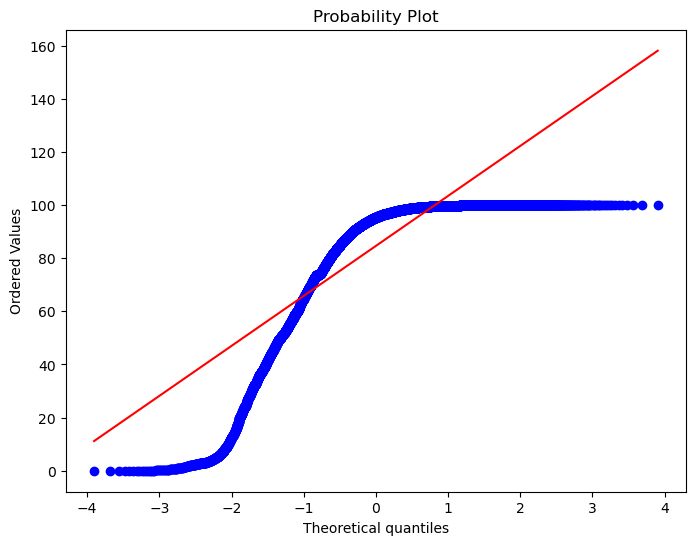

In [403]:
fig, ax = plt.subplots(figsize=(8, 6))
st.probplot(df['percent_human'], dist='norm', plot=plt)
plt.show()

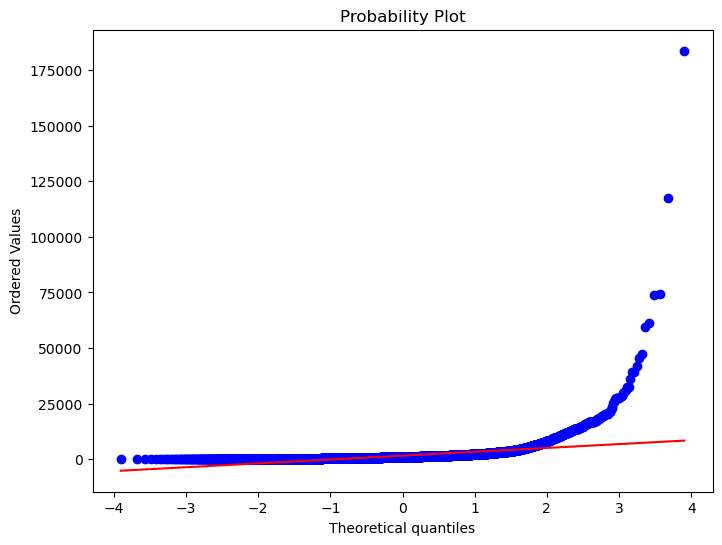

In [404]:
fig, ax = plt.subplots(figsize=(8, 6))
st.probplot(df['word_count'], dist='norm', plot=plt)
plt.show()

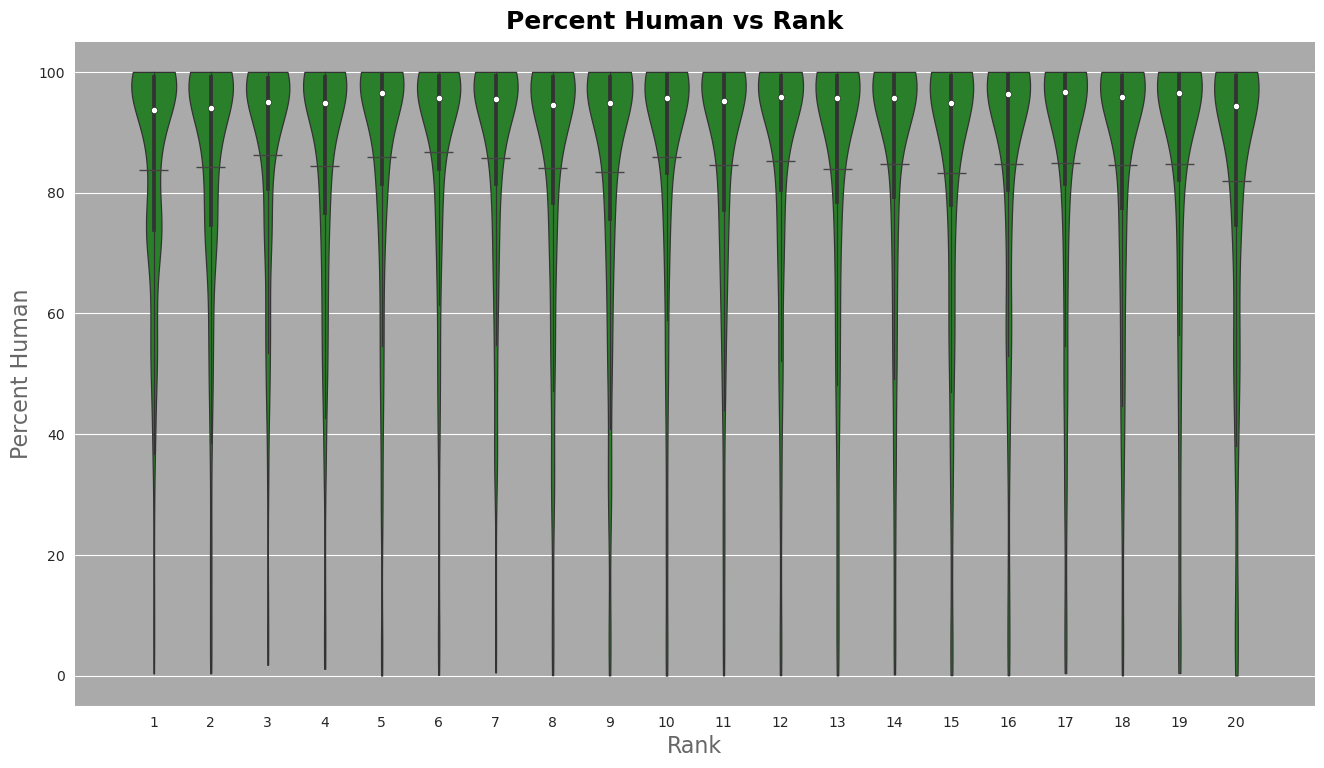

In [405]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(16, 8))

sns.violinplot(data=df, x="rank", y="percent_human", scale="count", inner="box", color="#00aa00", saturation=0.5, cut=0, linewidth=.9, edgecolor='#ffffff')
sns.despine(left=True)

for i, mean in enumerate(df.groupby("rank")["percent_human"].mean()):
    ax.hlines(mean, i-0.25, i+0.25, linewidth=1, color='#444444', zorder=100)

median_markers = df.groupby('rank')['percent_human'].median()
sns.scatterplot(x=median_markers.index-1, y=median_markers.values, marker='o', s=20, color='white', edgecolor='black', zorder=100)

fig.suptitle('Percent Human vs Rank', fontsize=18, fontweight='bold')
ax.set_facecolor('#aaaaaa')
fig.subplots_adjust(top=0.94)

ax.set_xlabel("Rank",size = 16,alpha=0.7)
ax.set_ylabel("Percent Human",size = 16,alpha=0.7)

plt.show()

<AxesSubplot: xlabel='rank', ylabel='percent_human'>

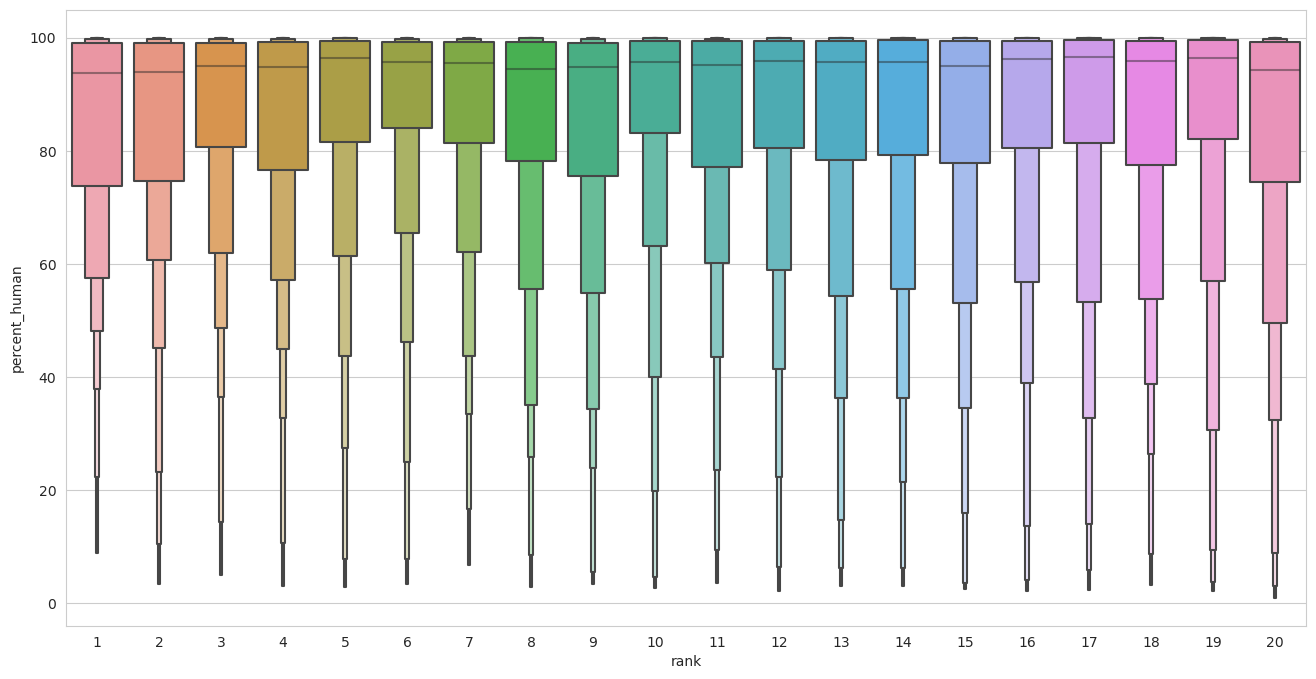

In [406]:
with sns.axes_style("whitegrid"):
    fig, axs = plt.subplots(figsize=(16, 8))
sns.boxenplot(data=df, x="rank", y="percent_human", showfliers=False)

/home/mike/miniconda3/envs/stats/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


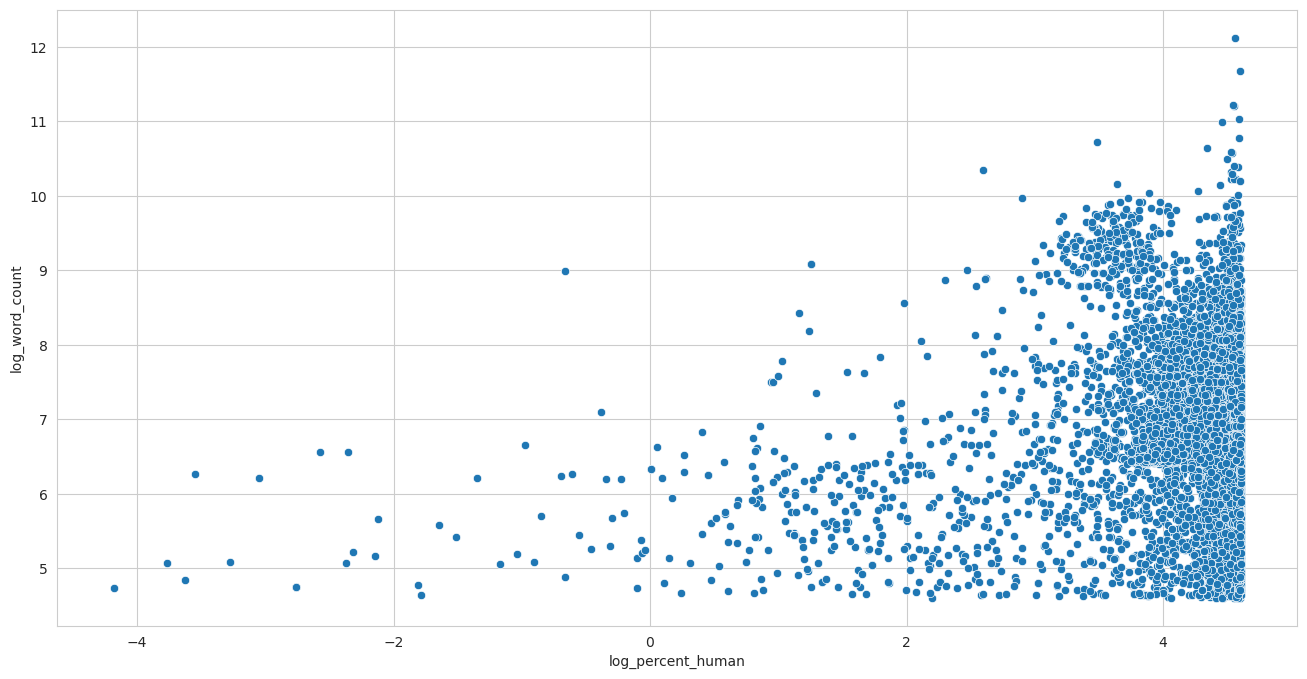

In [407]:
df2 = df.copy()
df2['log_word_count'] = np.log(df['word_count'])
df2['log_percent_human'] = np.log(df['percent_human'])

with sns.axes_style("whitegrid"):
    fig, axs = plt.subplots(figsize=(16, 8))
    sns.scatterplot(data=df2, x="log_percent_human", y="log_word_count")

/home/mike/miniconda3/envs/stats/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


                Correlation Coefficient       p-value
Point-Biserial                -0.031180  1.615923e-04
Spearman                      -0.114403  7.884151e-44
Kendall Tau                   -0.080917  9.456196e-49


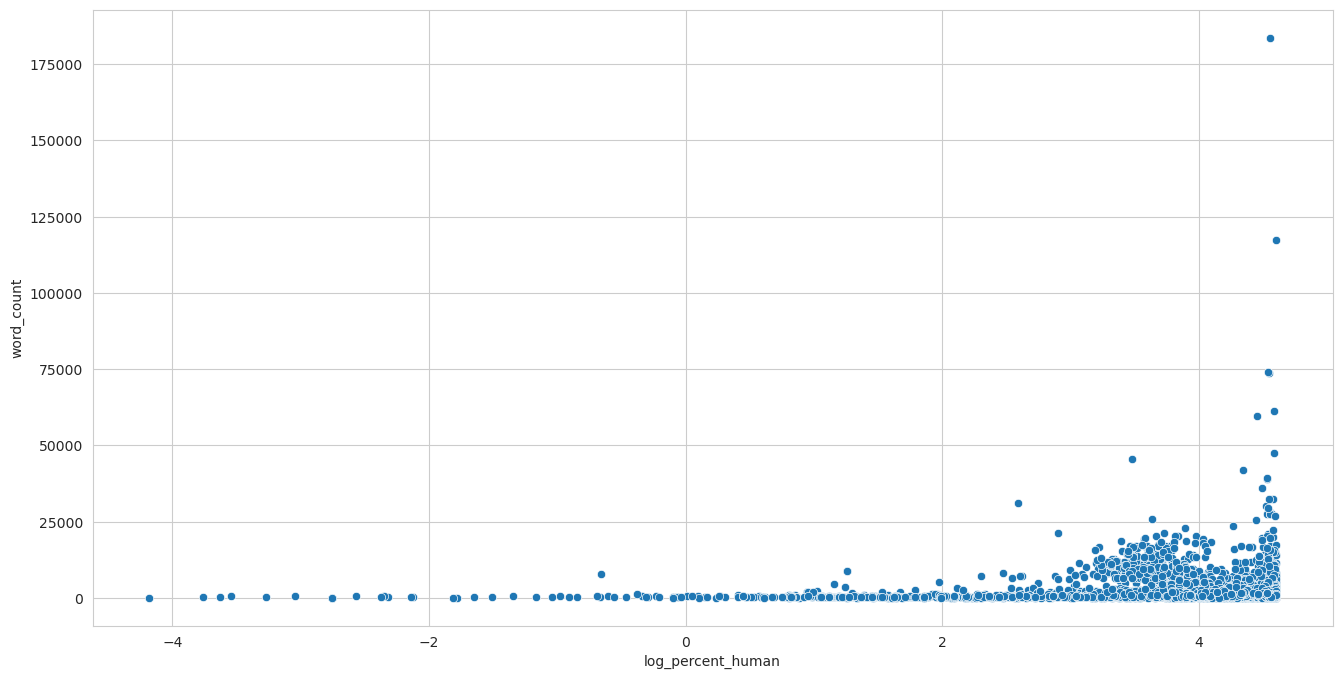

In [408]:
df2 = df.copy()
df2['log_percent_human'] = np.log(df['percent_human'])
df2['log_word_count'] = np.log(df['word_count'])
df2 = df2[~(df2[['log_percent_human', 'log_word_count']].isnull().any(axis=1) | df2[['log_percent_human', 'log_word_count']].isin([np.inf, -np.inf]).any(axis=1))]

with sns.axes_style("whitegrid"):
    fig, axs = plt.subplots(figsize=(16, 8))
sns.scatterplot(data=df2, x="log_percent_human", y ="word_count")

# Calculate the correlation coefficients and p-values
pb_corr, pb_pval = st.pointbiserialr(df2['word_count'], df2['log_percent_human'])
spearman_corr, spearman_pval = st.spearmanr(df2['word_count'], df2['log_percent_human'])
kendall_tau, kendall_pval = st.kendalltau(df2['word_count'], df2['log_percent_human'])

# Create a pandas dataframe to store the results
data = {'Correlation Coefficient': [pb_corr, spearman_corr, kendall_tau], 'p-value': [pb_pval, spearman_pval, kendall_pval]}
index = ['Point-Biserial', 'Spearman', 'Kendall Tau']
df_results = pd.DataFrame(data=data, index=index)

# Print the results dataframe
print(df_results)

/home/mike/miniconda3/envs/stats/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


                Correlation Coefficient       p-value
Point-Biserial                 0.085778  2.605599e-25
Spearman                      -0.114403  7.884151e-44
Kendall Tau                   -0.080917  9.456196e-49


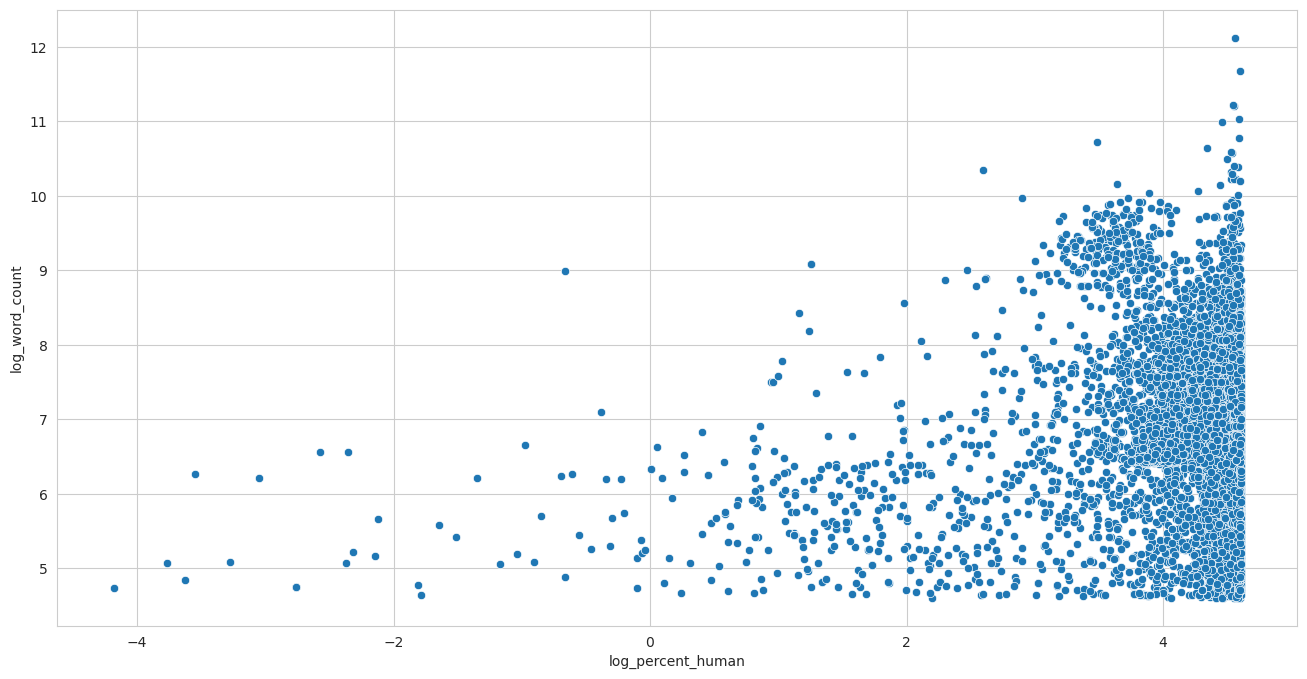

In [409]:
df2 = df.copy()
df2['log_percent_human'] = np.log(df['percent_human'])
df2['log_word_count'] = np.log(df['word_count'])
df2 = df2[~(df2[['log_percent_human', 'log_word_count']].isnull().any(axis=1) | df2[['log_percent_human', 'log_word_count']].isin([np.inf, -np.inf]).any(axis=1))]

with sns.axes_style("whitegrid"):
    fig, axs = plt.subplots(figsize=(16, 8))
sns.scatterplot(data=df2, x="log_percent_human", y ="log_word_count")

# Calculate the correlation coefficients and p-values
pb_corr, pb_pval = st.pointbiserialr(df2['log_word_count'], df2['log_percent_human'])
spearman_corr, spearman_pval = st.spearmanr(df2['log_word_count'], df2['log_percent_human'])
kendall_tau, kendall_pval = st.kendalltau(df2['log_word_count'], df2['log_percent_human'])

# Create a pandas dataframe to store the results
data = {'Correlation Coefficient': [pb_corr, spearman_corr, kendall_tau], 'p-value': [pb_pval, spearman_pval, kendall_pval]}
index = ['Point-Biserial', 'Spearman', 'Kendall Tau']
df_results = pd.DataFrame(data=data, index=index)

# Print the results dataframe
print(df_results)

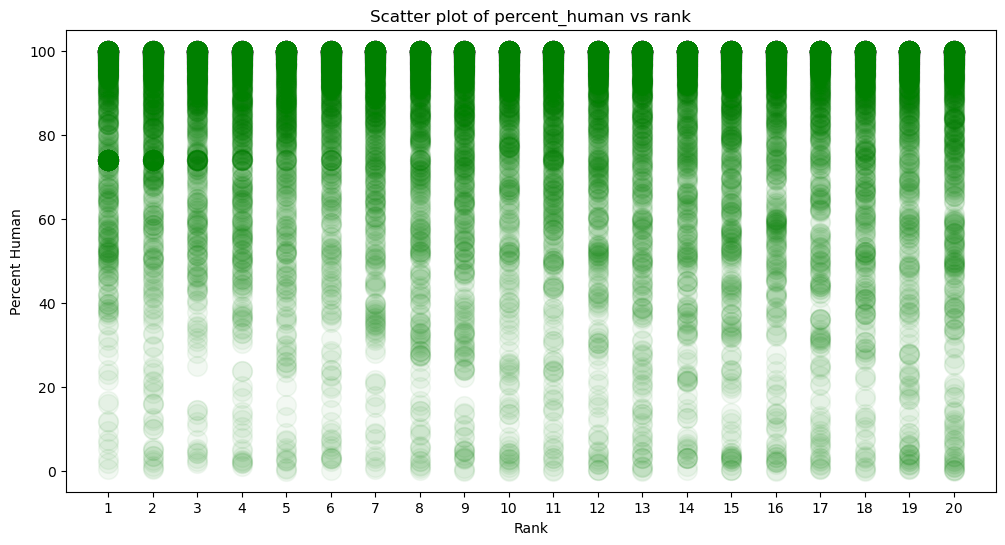

In [410]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.scatterplot(data=df, x='rank', y='percent_human', color='green', alpha=0.05, s=200, edgecolor=None)
ax.set_title('Scatter plot of percent_human vs rank')
ax.set_xlabel('Rank')
ax.set_ylabel('Percent Human')
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
plt.show()

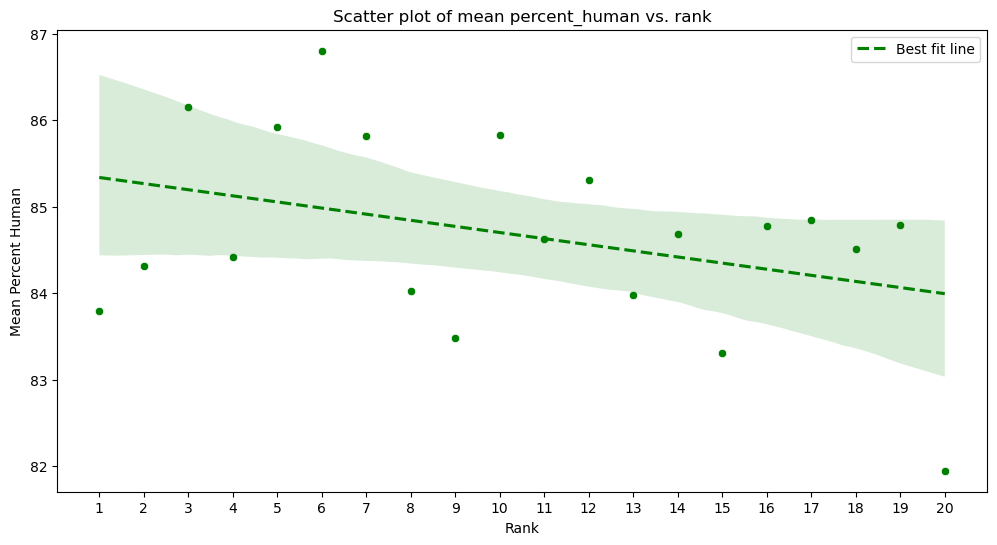

In [411]:
fig, ax = plt.subplots(figsize=(12, 6))
grouped_data = df.groupby('rank')
mean_percent_human = grouped_data['percent_human'].mean().reset_index()
sns.scatterplot(ax=ax, x='rank', y='percent_human', data=mean_percent_human, color='green')
sns.regplot(ax=ax, x='rank', y='percent_human', data=mean_percent_human, color='green', scatter=False, line_kws={'linestyle':'--'})
ax.set_title('Scatter plot of mean percent_human vs. rank')
ax.set_xlabel('Rank')
ax.set_ylabel('Mean Percent Human')
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
ax.legend(handles=ax.lines[::len(mean_percent_human)], labels=['Best fit line'])
plt.show()


In [412]:
# Calculate the correlation coefficients and p-values
pb_corr, pb_pval = st.pointbiserialr(df['rank'], df['percent_human'])
spearman_corr, spearman_pval = st.spearmanr(df['rank'], df['percent_human'])
kendall_tau, kendall_pval = st.kendalltau(df['rank'], df['percent_human'])

# Create a pandas dataframe to store the results
data = {'Correlation Coefficient': [pb_corr, spearman_corr, kendall_tau], 'p-value': [pb_pval, spearman_pval, kendall_pval]}
index = ['Point-Biserial', 'Spearman', 'Kendall Tau']
df_results = pd.DataFrame(data=data, index=index)

# Print the results dataframe
print(df_results)

                Correlation Coefficient   p-value
Point-Biserial                -0.018081  0.028703
Spearman                       0.024955  0.002533
Kendall Tau                    0.017242  0.002268


In [413]:
# Calculate the point-biserial correlation coefficient and p-value
pb_corr, pb_pval = st.pointbiserialr(df['rank'], df['percent_human'])

print("Point-biserial correlation coefficient: {:.3f}".format(pb_corr))
print("p-value: {:.3f}".format(pb_pval))

Point-biserial correlation coefficient: -0.018
p-value: 0.029


In [414]:
spearman_corr, spearman_pval = st.spearmanr(df['rank'], df['percent_human'])
print("Spearman correlation:", spearman_corr)
print("p-value:", spearman_pval)

Spearman correlation: 0.02495527958361103
p-value: 0.002532853793591697


In [415]:
kendall_tau, kendall_pval = st.kendalltau(df['rank'], df['percent_human'])
print("Kendall's Tau correlation:", kendall_tau)
print("p-value:", kendall_pval)

Kendall's Tau correlation: 0.017242445407663405
p-value: 0.002268000555651608


In [416]:
spearman_corr, spearman_pval = st.spearmanr(df['percent_human'], df['word_count'])
print("Spearman correlation:", spearman_corr)
print("p-value:", spearman_pval)

Spearman correlation: -0.114001937195072
p-value: 1.5392917531131827e-43


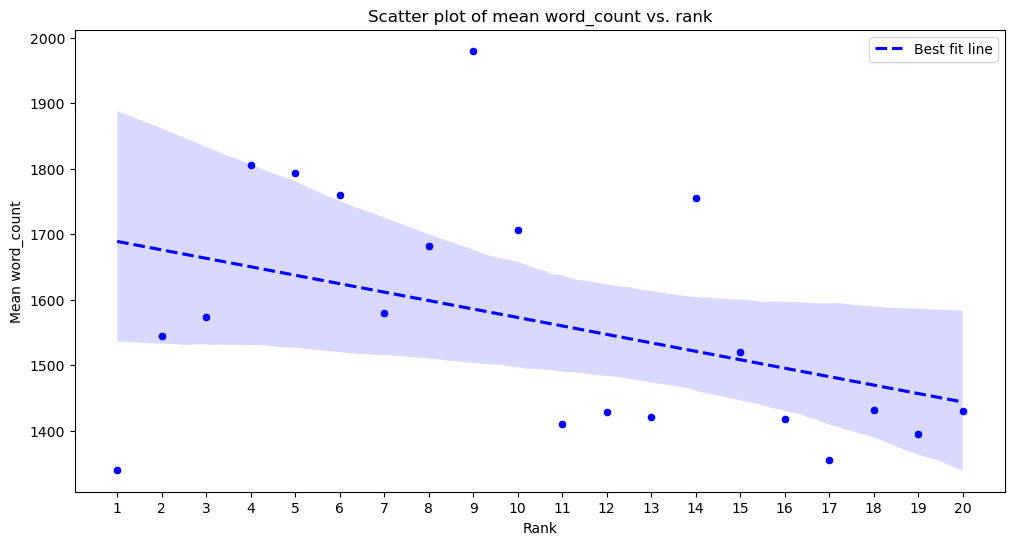

In [417]:
fig, ax = plt.subplots(figsize=(12, 6))
grouped_data = df.groupby('rank')
mean_percent_human = grouped_data['word_count'].mean().reset_index()
sns.scatterplot(ax=ax, x='rank', y='word_count', data=mean_percent_human, color='blue')
sns.regplot(ax=ax, x='rank', y='word_count', data=mean_percent_human, color='blue', scatter=False, line_kws={'linestyle':'--'})
ax.set_title('Scatter plot of mean word_count vs. rank')
ax.set_xlabel('Rank')
ax.set_ylabel('Mean word_count')
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
ax.legend(handles=ax.lines[::len(mean_percent_human)], labels=['Best fit line'])
plt.show()

In [418]:
correlations = df.groupby('kw')[['rank', 'percent_human']].corr()
correlations

rank  percent_human
kw                                                           
/lh meaning            rank           1.000000       0.074228
                       percent_human  0.074228       1.000000
2 pole breaker         rank           1.000000      -0.012722
                       percent_human -0.012722       1.000000
205/75r14 trailer tire rank           1.000000       0.003305
...                                        ...            ...
yor forger cosplay     percent_human -0.140728       1.000000
zinus bed frame        rank           1.000000      -0.221257
                       percent_human -0.221257       1.000000
zip up bedding         rank           1.000000       0.369372
                       percent_human  0.369372       1.000000

[2000 rows x 2 columns]

In [419]:
correlations = df.groupby('kw')[['rank', 'percent_human', 'word_count']].corr().iloc[::2,-1].to_frame()
correlations

word_count
kw                                              
/lh meaning            rank            -0.279160
                       word_count       1.000000
2 pole breaker         percent_human   -0.808909
205/75r14 trailer tire rank             0.677676
                       word_count       1.000000
...                                          ...
yoni pearls            word_count       1.000000
yor forger cosplay     percent_human   -0.316037
zinus bed frame        rank             0.456368
                       word_count       1.000000
zip up bedding         percent_human   -0.687084

[1500 rows x 1 columns]

In [420]:
correlations = df[['rank', 'word_count', 'percent_human']].corr(method='spearman').iloc[1::3, :]
correlations

,rank,word_count,percent_human
word_count,-0.074348,1.0,-0.114002


In [421]:
correlations = df.groupby('kw')[['rank', 'percent_human', 'word_count']].corr(method='spearman').unstack()[['rank', 'percent_human', 'word_count']].iloc[1::3, :]
correlations

rank                           \
                                               rank percent_human word_count   
kw                                                                             
2 pole breaker                                  1.0      0.203596  -0.706599   
3 subject notebook                              1.0     -0.261905   0.190476   
707 street                                      1.0      0.542857  -0.714286   
9 year anniversary gift traditional and modern  1.0      0.088235  -0.597059   
acid reflux treatment at home                   1.0      0.186791  -0.374613   
...                                             ...           ...        ...   
world health organization travel passport       1.0     -0.276961   0.063725   
xel 3a cardholder cases                         1.0      0.800000   0.600000   
yard landscaping                                1.0     -0.120879  -0.331868   
yellow crookneck squash                         1.0     -0.038235  -0.282353   
yor forger cosplay                              1.0      0.010989  -0.423077   

                                               percent_human                \
                                                        rank percent_human   
kw                                                                           
2 pole breaker                                      0.203596           1.0   
3 subject notebook                                 -0.261905           1.0   
707 street                                          0.542857           1.0   
9 year anniversary gift traditional and modern      0.088235           1.0   
acid reflux treatment at home                       0.186791           1.0   
...                                                      ...           ...   
world health organization travel passport          -0.276961           1.0   
xel 3a cardholder cases                             0.800000           1.0   
yard landscaping                                   -0.120879           1.0   
yellow crookneck squash                            -0.038235           1.0   
yor forger cosplay                                  0.010989           1.0   

                                                          word_count  \
                                               word_count       rank   
kw                                                                     
2 pole breaker                                  -0.614458  -0.706599   
3 subject notebook                              -0.261905   0.190476   
707 street                                       0.028571  -0.714286   
9 year anniversary gift traditional and modern  -0.617647  -0.597059   
acid reflux treatment at home                   -0.702786  -0.374613   
...                                                   ...        ...   
world health organization travel passport       -0.071078   0.063725   
xel 3a cardholder cases                          0.800000   0.600000   
yard landscaping                                 0.059341  -0.331868   
yellow crookneck squash                         -0.073529  -0.282353   
yor forger cosplay                              -0.192308  -0.423077   

                                                                         
                                               percent_human word_count  
kw                                                                       
2 pole breaker                                     -0.614458        1.0  
3 subject notebook                                 -0.261905        1.0  
707 street                                          0.028571        1.0  
9 year anniversary gift traditional and modern     -0.617647        1.0  
acid reflux treatment at home                      -0.702786        1.0  
...                                                      ...        ...  
world health organization travel passport          -0.071078        1.0  
xel 3a cardholder cases                             0.800000        1.0  
yard lands

In [422]:
correlations = df.groupby('kw')[['rank', 'percent_human', 'word_count']].corr(method='spearman').unstack().iloc[:, 1::3]
correlations

,rank,percent_human,word_count
,percent_human,percent_human,percent_human
kw,,,
/lh meaning,0.180518,1.0,0.137746
2 pole breaker,0.203596,1.0,-0.614458
205/75r14 trailer tire,-0.178571,1.0,-0.214286
21 lessons for the 21st century,-0.381818,1.0,-0.281818
3 subject notebook,-0.261905,1.0,-0.261905
...,...,...,...
yellow slip dress,-0.285714,1.0,-0.619048
yoni pearls,-0.432353,1.0,0.102941


In [423]:
correlations

,rank,percent_human,word_count
,percent_human,percent_human,percent_human
kw,,,
/lh meaning,0.180518,1.0,0.137746
2 pole breaker,0.203596,1.0,-0.614458
205/75r14 trailer tire,-0.178571,1.0,-0.214286
21 lessons for the 21st century,-0.381818,1.0,-0.281818
3 subject notebook,-0.261905,1.0,-0.261905
...,...,...,...
yellow slip dress,-0.285714,1.0,-0.619048
yoni pearls,-0.432353,1.0,0.102941


In [424]:
df2 = correlations['rank']['percent_human']
df2

kw
/lh meaning                        0.180518
2 pole breaker                     0.203596
205/75r14 trailer tire            -0.178571
21 lessons for the 21st century   -0.381818
3 subject notebook                -0.261905
                                     ...   
yellow slip dress                 -0.285714
yoni pearls                       -0.432353
yor forger cosplay                 0.010989
zinus bed frame                   -0.090909
zip up bedding                     0.336364
Name: percent_human, Length: 1000, dtype: float64

In [425]:
df_wc_500 = df[df['word_count'] < 500]

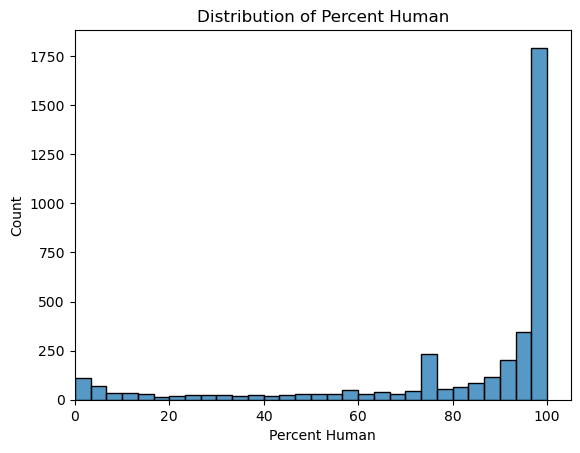

In [426]:
sns.histplot(df_wc_500['percent_human'], kde=False)
plt.title('Distribution of Percent Human')
plt.xlabel('Percent Human')
plt.ylabel('Count')
plt.xlim(0)
plt.ylim(0)
plt.show()

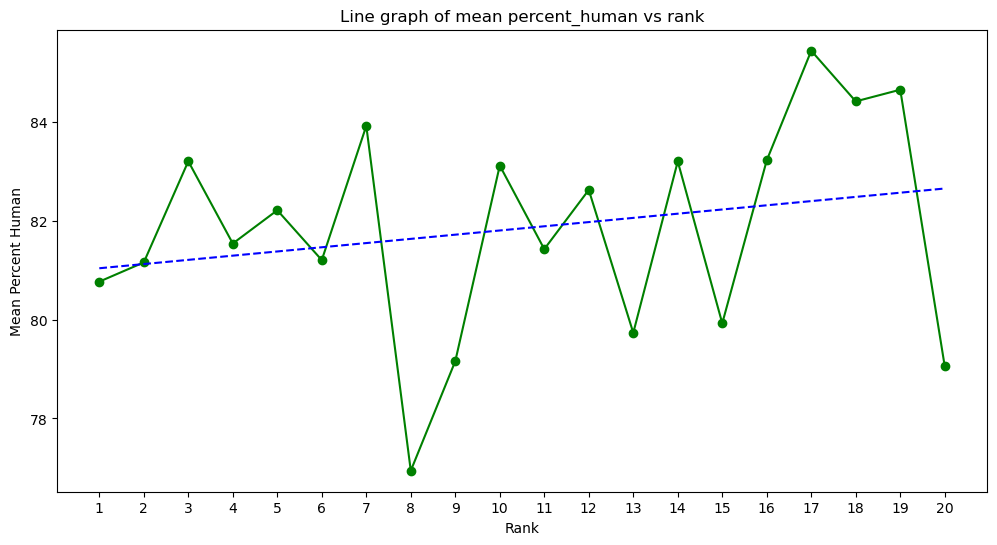

In [427]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 6))

# Group the data by 'rank'
grouped_data = df_wc_500.groupby('rank')

# Calculate the mean of 'percent_human' for each rank
mean_percent_human = grouped_data['percent_human'].mean()

# Plot the line graph of mean percent_human vs rank
ax.plot(mean_percent_human.index, mean_percent_human, color='green', marker='o')

# Set the title and axis labels
ax.set_title('Line graph of mean percent_human vs rank')
ax.set_xlabel('Rank')
ax.set_ylabel('Mean Percent Human')

# Set the xticks to integers from 1 to 20
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

# Add a best fit line
x = mean_percent_human.index
y = mean_percent_human.values
slope, intercept = np.polyfit(x, y, 1)
ax.plot(x, slope*x + intercept, color='blue', linestyle='--')

# Show the plot
plt.show()

In [428]:
spearman_corr, spearman_pval = st.spearmanr(df_wc_500['rank'], df_wc_500['percent_human'])
print("Spearman correlation:", spearman_corr)
print("p-value:", spearman_pval)

Spearman correlation: 0.07069466329593875
p-value: 1.978568343901353e-05


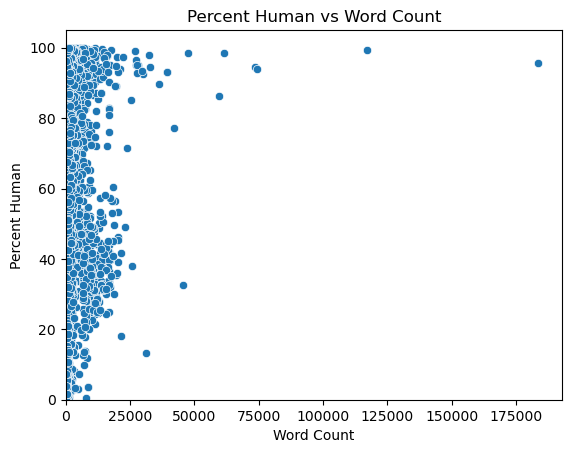

In [429]:
ax = sns.scatterplot(data=df, x='word_count', y='percent_human', hue=None, size=None, style=None, palette=None, hue_order=None, hue_norm=None, sizes=None, size_order=None, size_norm=None, markers=True, style_order=None, legend='auto', ax=None)
ax.set(title='Percent Human vs Word Count', xlabel='Word Count', ylabel='Percent Human', xlim=(0, None), ylim=(0, None))
plt.show()

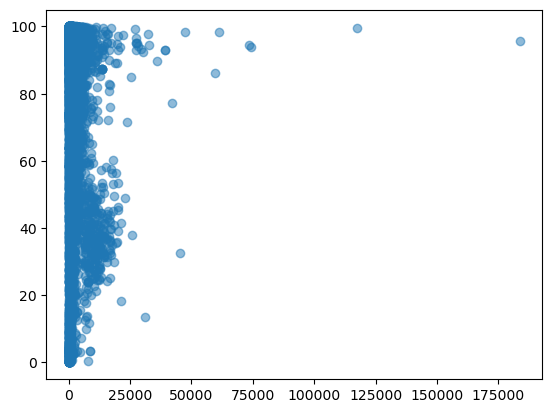

In [430]:
ax = plt.scatter(df['word_count'], df['percent_human'], alpha=0.5)
#ax.set(title='Percent Human vs Word Count', xlabel='Word Count', ylabel='Percent Human', xlim=(0, None), ylim=(0, None))
plt.show()

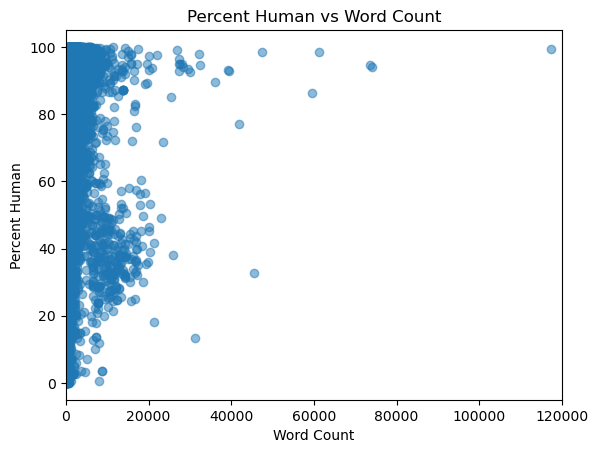

In [431]:
plt.scatter(df['word_count'], df['percent_human'], alpha=0.5)
plt.xlabel('Word Count')
plt.ylabel('Percent Human')
plt.title('Percent Human vs Word Count')
plt.xlim([0, 120000])  # set x-axis limits
plt.show()

In [432]:
# Create the interval range
bins = pd.interval_range(start=0, end=100, freq=5)

# Create a new column 'bin' that contains the bin labels for each observation
df['bin'] = pd.cut(df['percent_human'], bins)

# Initialize an empty DataFrame to hold the sampled observations
new_df = pd.DataFrame()

# Sample 55 observations from each bin and append them to the new DataFrame
for interval in bins:
    sampled_obs = df[df['bin'] == interval].sample(n=55, replace = False, random_state=42)
    new_df = pd.concat([new_df, sampled_obs])

# Reset the index of the new DataFrame
new_df = new_df.reset_index(drop=True)
new_df


,kw,rank,link,success,word_count,percent_human,percent_ai,uid,Adwords bottom,Adwords sitelink,Adwords top,Featured snippet,Image pack,Knowledge card,Knowledge panel,Local pack,Local teaser,People also ask,Shopping results,Sitelinks,Thumbnail,Top stories,Tweet box,Video preview,Videos,log_percent_human,bin
0,goat weed,2,https://www.webmd.com/men/horny-goat-weed-epim...,True,315.0,4.993183,95.006818,goat weed_2_https://www.webmd.com/men/horny-go...,0,0,0,0,0,0,1,0,0,1,1,1,1,0,0,0,0,0.698377,"(0, 5]"
1,banana trees,14,https://stock.adobe.com/search?k=banana%20tree,True,231.0,3.062132,96.937871,banana trees_14_https://stock.adobe.com/search...,0,0,0,0,0,0,1,0,0,1,1,0,1,1,0,0,0,0.486024,"(0, 5]"
2,treehouse for kids,15,https://www.magictreehouse.com/,True,484.0,3.571149,96.428853,treehouse for kids_15_https://www.magictreehou...,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0.552808,"(0, 5]"
3,stages of wound healing pictures,6,https://stock.adobe.com/search?k=wound%20healing,True,231.0,3.062132,96.937871,stages of wound healing pictures_6_https://sto...,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0.486024,"(0, 5]"
4,the lost book of herbal remedies,15,https://carolinareadiness.com/products/the-los...,True,159.0,0.093248,99.906749,the lost book of herbal remedies_15_https://ca...,0,0,0,0,1,0,1,0,0,1,1,1,1,0,0,0,0,-1.030360,"(0, 5]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,elephant ear,2,https://hort.extension.wisc.edu/articles/eleph...,True,1499.0,99.879803,0.120196,elephant ear_2_https://hort.extension.wisc.edu...,0,0,0,0,0,0,1,0,0,1,1,1,1,1,0,0,0,1.999478,"(95, 100]"
1096,how to repair a hole in drywall,11,https://www.thisoldhouse.com/walls/21015080/ho...,True,423.0,99.967694,0.032312,how to repair a hole in drywall_11_https://www...,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1.999860,"(95, 100]"
1097,mold removal services,14,https://www.moldmanusa.com/post/what-you-shoul...,True,1118.0,95.937192,4.062804,mold removal services_14_https://www.moldmanus...,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1.981987,"(95, 100]"
1098,bad acne,10,https://www.healthline.com/health/severe-acne/...,True,1762.0,96.811713,3.188287,bad acne_10_https://www.healthline.com/health/...,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1.985928,"(95, 100]"


In [433]:
bins = pd.interval_range(start=0, end=100, freq=5)
df['bin'] = pd.cut(df['percent_human'], bins)

# randomly sample exactly 55 values from each bin
sample_size = 55
new_df = df.groupby('bin').apply(lambda x: x.sample(n=min(len(x), sample_size), random_state=np.random.RandomState(42)) if len(x) >= sample_size else x)

# reset index and drop the original index
new_df = new_df.reset_index(drop=True)

In [434]:
spearman_corr, spearman_pval = st.spearmanr(new_df['rank'], new_df['percent_human'])
print("Spearman correlation:", spearman_corr)
print("p-value:", spearman_pval)

Spearman correlation: -0.10820621888117933
p-value: 0.0003240492974351133


In [435]:
kendall_tau, kendall_pval = st.kendalltau(new_df['rank'], new_df['percent_human'])
print("Kendall's Tau correlation:", kendall_tau)
print("p-value:", kendall_pval)

Kendall's Tau correlation: -0.0738793308149277
p-value: 0.000342099037084246


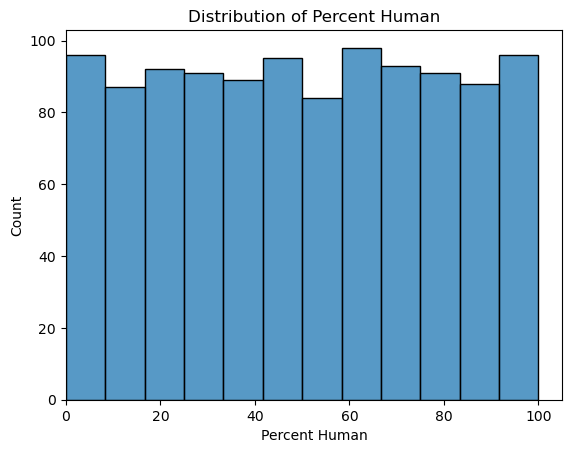

In [436]:
ax = sns.histplot(new_df['percent_human'], kde=False)
ax.set(title='Distribution of Percent Human', xlabel='Percent Human', ylabel='Count', xlim=(0, None), ylim=(0, None))
#ax.text(0.05, 0.95, 'Our data is not normally distrubuted\nand cannot be evaluated using Pearson\'s method', transform=ax.transAxes, fontsize=8, verticalalignment='top', color='blue')
plt.show()

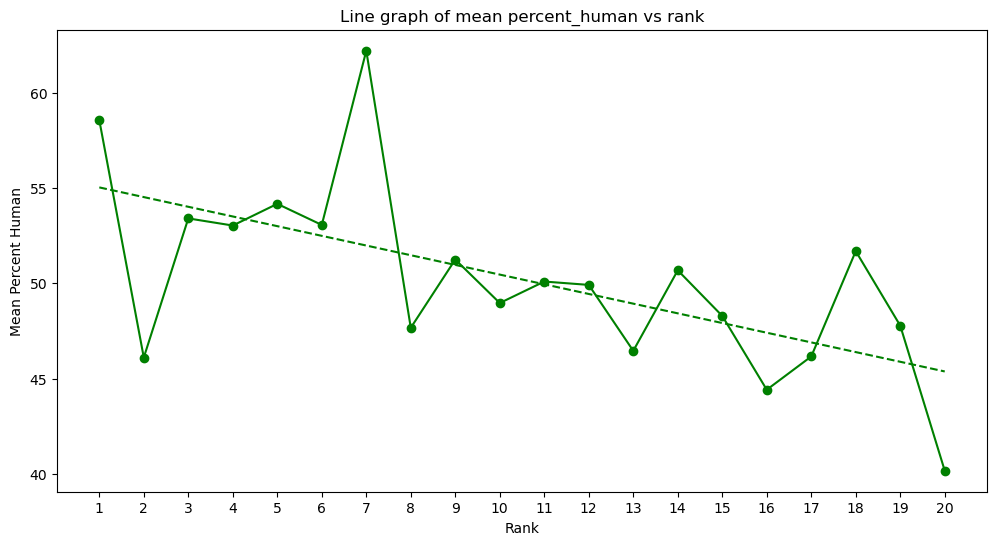

In [437]:
fig, ax = plt.subplots(figsize=(12, 6))
grouped_data = new_df.groupby('rank')
mean_percent_human = grouped_data['percent_human'].mean()

ax.plot(mean_percent_human.index, mean_percent_human, color='green', marker='o')

# Set the title and axis labels
ax.set_title('Line graph of mean percent_human vs rank')
ax.set_xlabel('Rank')
ax.set_ylabel('Mean Percent Human')
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

# Add a best fit line
x = mean_percent_human.index
y = mean_percent_human.values
slope, intercept = np.polyfit(x, y, 1)
ax.plot(x, slope*x + intercept, color='green', linestyle='--')

plt.show()

In [438]:
# def add_df_to_df(df, combined_df, uid_col):
#     # Create a dictionary mapping uid to the relevant columns in combined_df
#     uid_to_data = {}
#     for i, row in combined_df.iterrows():
#         uid_to_data[row[uid_col]] = row[['SERP features', 'Volume']]
#     # Add new columns to df with the matching data for each uid
#     df[['SERP features', 'Volume']] = df[uid_col].apply(lambda uid: pd.Series(uid_to_data.get(uid, [None, None])))
#     return df

In [439]:
# def add_dict_to_df(df, kw_1000_dict, uid_col):
#     # Create a dictionary mapping uids to the corresponding SERP features and volume
#     uid_to_data = {uid: data for uid, data in kw_1000_dict.items() if uid in df[uid_col].unique()}
#     # Add new columns to df with the matching data for each uid
#     df[['SERP features', 'Volume']] = df[uid_col].apply(lambda uid: pd.Series(uid_to_data.get(uid, [None, None])))
#     return df
